In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
import glob

from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_filter

from galaxy_tools import load_halo, load_sim, mask_sim_to_halo, get_mock_observation
from general_tools import measure_surfbright, radius_of_param_limit
from sersic_tools import fit_sersic, sersic

%matplotlib inline
pd.set_option('display.max_columns', None)


Couldn't import numba. Missing:
abg_python.all_utils.get_cylindrical_velocities
Missing firefly, obtain it at http://github.com/ageller/Firefly or pip install firefly.


In [3]:
# load all images

image_files_list = glob.glob('../mock_image_files_round2/*.npy')


m11c_res2100
../mass_mock_images/m11c_res2100_massmock_yz_FOV18_sml_5.npy


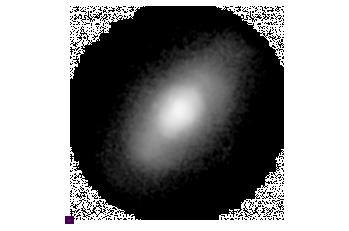

m10i_res500
../mass_mock_images/m10i_res500_massmock_zx_FOV4_sml_12.npy


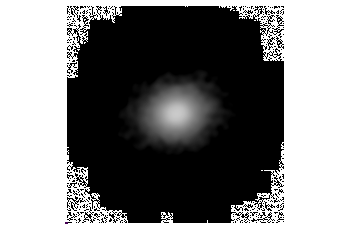

m10d_res500
../mass_mock_images/m10d_res500_massmock_zx_FOV3_sml_25.npy


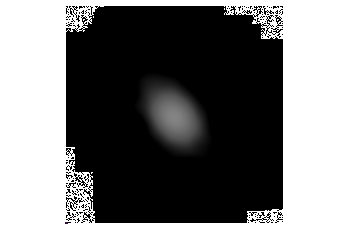

m10m_res500
../mass_mock_images/m10m_res500_massmock_yz_FOV5_sml_14.npy


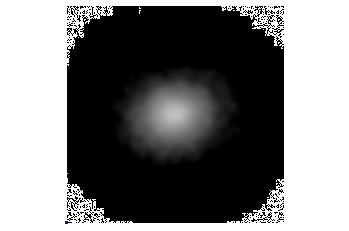

m11e_res7100
../mass_mock_images/m11e_res7100_massmock_xy_FOV30_sml_4.npy


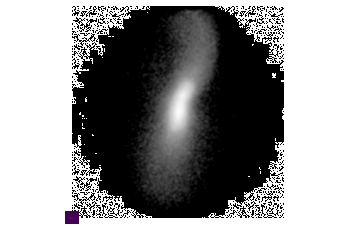

m11e_res7100
../mass_mock_images/m11e_res7100_massmock_zx_FOV30_sml_4.npy


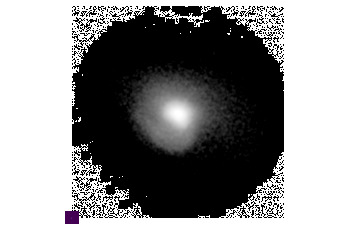

m10i_res500
../mass_mock_images/m10i_res500_massmock_yz_FOV4_sml_12.npy


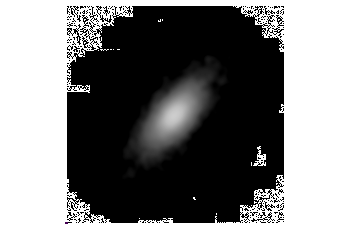

m10d_res500
../mass_mock_images/m10d_res500_massmock_yz_FOV3_sml_25.npy


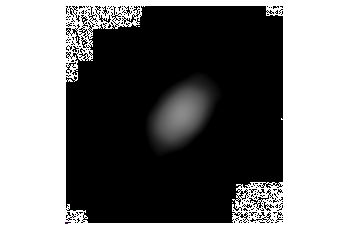

m10g_res500
../mass_mock_images/m10g_res500_massmock_xy_FOV4_sml_19.npy


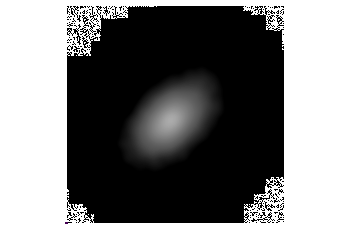

m11q_res7100
../mass_mock_images/m11q_res7100_massmock_zx_FOV20_sml_6.npy


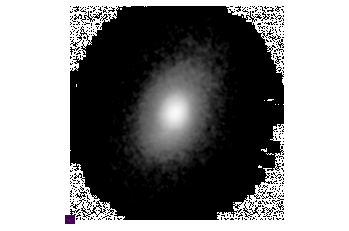

m11i_res7100
../mass_mock_images/m11i_res7100_massmock_zx_FOV20_sml_8.npy


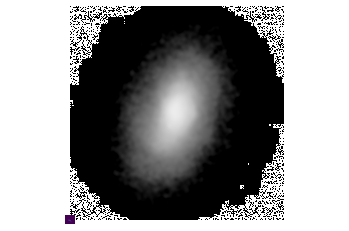

m10m_res500
../mass_mock_images/m10m_res500_massmock_zx_FOV5_sml_14.npy


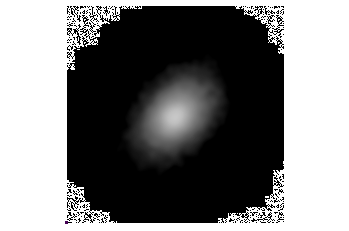

m11i_res7100
../mass_mock_images/m11i_res7100_massmock_xy_FOV20_sml_8.npy


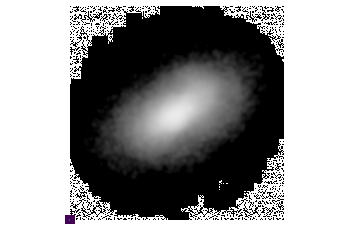

m11q_res7100
../mass_mock_images/m11q_res7100_massmock_xy_FOV20_sml_6.npy


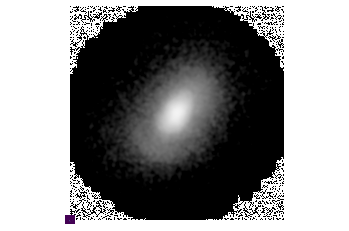

m10c_res500
../mass_mock_images/m10c_res500_massmock_xy_FOV3_sml_25.npy


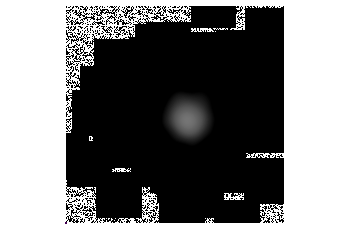

m10h_res500
../mass_mock_images/m10h_res500_massmock_yz_FOV4_sml_19.npy


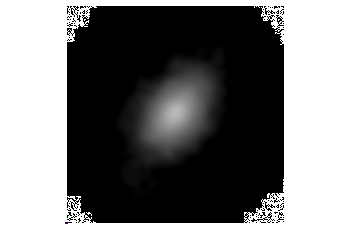

m10e_res500
../mass_mock_images/m10e_res500_massmock_yz_FOV3_sml_28.npy


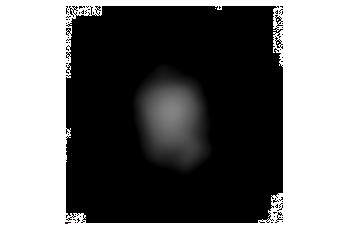

m10f_res500
../mass_mock_images/m10f_res500_massmock_xy_FOV5_sml_16.npy


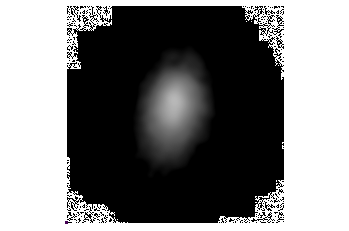

m11q_res7100
../mass_mock_images/m11q_res7100_massmock_yz_FOV20_sml_6.npy


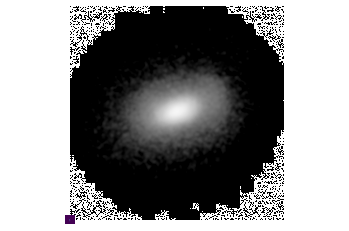

m11i_res7100
../mass_mock_images/m11i_res7100_massmock_yz_FOV20_sml_8.npy


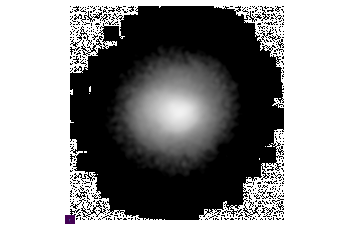

m10b_res500
../mass_mock_images/m10b_res500_massmock_xy_FOV3_sml_24.npy


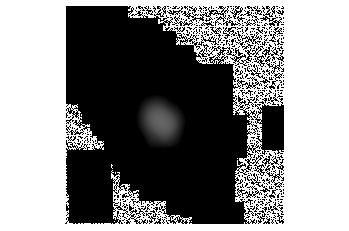

m10l_res500
../mass_mock_images/m10l_res500_massmock_zx_FOV5_sml_12.npy


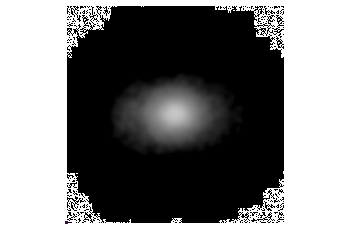

m11c_res2100
../mass_mock_images/m11c_res2100_massmock_zx_FOV18_sml_5.npy


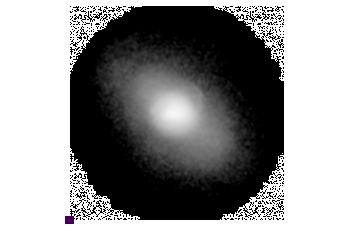

m11c_res2100
../mass_mock_images/m11c_res2100_massmock_xy_FOV18_sml_5.npy


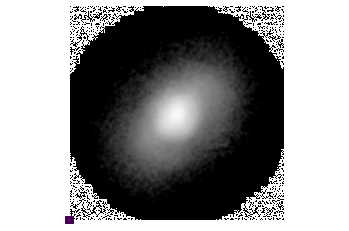

m10h_res500
../mass_mock_images/m10h_res500_massmock_zx_FOV4_sml_19.npy


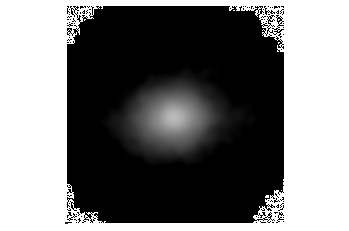

m10e_res500
../mass_mock_images/m10e_res500_massmock_zx_FOV3_sml_28.npy


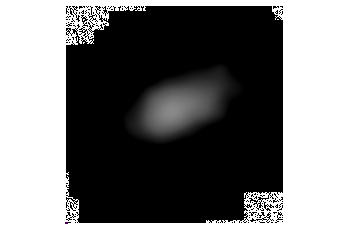

m10k_res500
../mass_mock_images/m10k_res500_massmock_xy_FOV5_sml_18.npy


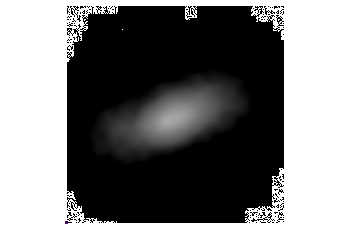

m11e_res7100
../mass_mock_images/m11e_res7100_massmock_yz_FOV30_sml_4.npy


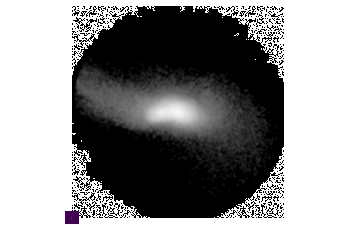

m10l_res500
../mass_mock_images/m10l_res500_massmock_yz_FOV5_sml_12.npy


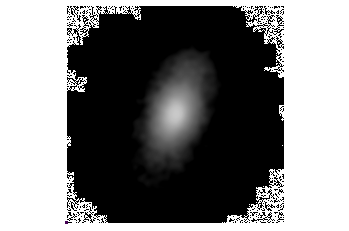

In [7]:
for file in image_files_list[62:]:
    image_file = file.split("/")[-1]
    image_params = image_file.split('_')
    image_type = image_params[2]
    FOV = int(image_params[-2][3:])
    view = image_params[-3]
    sim = image_params[0]+'_'+image_params[1]
    pixel = 1000
    
    kpctopix = pixel / (FOV*2)
    pixtokpc = kpctopix**-1
    
    #Run through my mock images
    if image_type == 'ugrband':
        if sim in ['m10b_res500', 'm10c_res500', 'm10d_res500', 
                   'm10e_res500', 'm10f_res500', 'm10g_res500',
                   'm10h_res500','m10i_res500', 'm10j_res500',
                   'm10k_res500','m10l_res500','m10m_res500','m10q_res250']:
            snap_num = 184
            filetype = 'ascii'
            halo_path = '/data17/grenache/aalazar/FIRE/GVB/'+str(sim)+'/halo/rockstar_dm/catalog/'
        
        elif sim in ['m11a_res2100','m11b_res2100','m11c_res2100', 
                     'm11d_res7100', 'm11e_res7100','m11h_res7100',
                     'm11i_res7100','m11q_res7100','m11v_res7100']:
            snap_num = 600
            filetype = 'hdf5'
            halo_path = '/data17/grenache/aalazar/FIRE/GVB/'+str(sim)+'/halo/rockstar_dm/hdf5/'
        
        halo = load_halo(halo_path, snap_num, host=True, filetype=filetype)

        sim_path =  '/data17/grenache/aalazar/FIRE/GVB/'+str(sim)+'/output/hdf5/snapdir_'+str(snap_num)+'/'
        star_snapdict, gas_snapdict = load_sim(sim_path,snap_num)
                
        star_snapdict, gas_snapdict, halo = mask_sim_to_halo(star_snapdict=star_snapdict,
                                                             gas_snapdict=gas_snapdict, 
                                                             host_halo=halo, 
                                                             orient=False, #if true, then orients toward disk
                                                             lim = True, #Masks particles beyond limvalue  
                                                             limvalue = FOV #Same lim as mock image
                                                            )
        
        #Need the coordiantes in this order for the mass images to match mock's orientation

        if view == 'xy':
            Mass = plt.hist2d(star_snapdict['Coordinates'][:,1],star_snapdict['Coordinates'][:,0],
                       weights=star_snapdict['Masses'], bins=pixel)
        elif view == 'yz':
            Mass = plt.hist2d(star_snapdict['Coordinates'][:,2],star_snapdict['Coordinates'][:,1],
                       weights=star_snapdict['Masses'], bins=pixel)   
        elif view == 'zx':
            Mass = plt.hist2d(star_snapdict['Coordinates'][:,0],star_snapdict['Coordinates'][:,2],
                       weights=star_snapdict['Masses'], bins=pixel)
        
        #Convert unit from mass/pixel^2 to mass/kpc^2
        SigmaMass = Mass[0][::-1] * (pixtokpc)**-2 
        # Smooth based on the median smoothing length of star particle
        smooth = int(np.median(star_snapdict['hsml'])*kpctopix)
        SigmaMass_smoothed = gaussian_filter(SigmaMass, sigma=smooth )
        
        save_file_name = '../mass_mock_images/' + sim + '_massmock_' + view + '_FOV' + str(FOV) + '_sml_' + str(smooth) + '.npy'
        
        np.save(save_file_name, SigmaMass_smoothed)
        print(sim)
        print(save_file_name)
        Mass_image = plt.imshow(SigmaMass_smoothed, norm=colors.LogNorm(vmin=57650, vmax=1e8),cmap='Greys_r')
        plt.gca().axis('equal')
        plt.gca().axis('off')
        plt.show()



